## 📚 Imports dan Setup Awal

In [1]:
import os
import torch
import gc

# Force PyTorch-only mode (prevents TensorFlow conflicts)
os.environ["USE_TORCH"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

print(" TensorFlow conflict mitigated")

def clear_gpu_memory():
    """Clear GPU cache to prevent memory issues"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    gc.collect()

 TensorFlow conflict mitigated


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Basic
import pandas as pd
import numpy as np
import re
import json
import html
import requests
from collections import Counter
from tqdm import tqdm
from difflib import SequenceMatcher
import random

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from mpstemmer import MPStemmer
import emoji

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from wordcloud import WordCloud

# ML & Clustering
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import hdbscan
import umap

# Deep Learning
from transformers import AutoModelForCausalLM, AutoModel, AutoTokenizer, BertTokenizer, BitsAndBytesConfig

# Network Analysis
import networkx as nx


# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

print(" All libraries imported successfully")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)


 All libraries imported successfully
 Using device: cuda


## ⚙️ Configuration Parameters

In [ ]:
# Visualization
WC_MAX_WORDS = 200
WC_FIGSIZE = (20, 10)

print(" Configuration complete")

 Configuration complete


## 📥 1. Data Loading

In [ ]:
dataset_path = 'data/comments_tanboykun.csv' 

if os.path.exists(dataset_path):
    df = pd.read_csv(dataset_path)
    print(f"Berhasil memuat {len(df)} data dari {dataset_path}")
else:
    print("File tidak ditemukan! Pastikan struktur folder sudah benar.")

print(f"Data loaded: {len(df)} comments")
print(f"Columns: {df.columns.tolist()}")

# Display sample
print("\nSample data:")
display(df.head(3))

Data loaded: 2411 comments
Columns: ['Comment']

Sample data:


,Comment
0,D mana ituuuuu
1,Sekelas fanboy kun aja kepedesan apalagi yg kayak gua😂😂😂
2,"Tanboy kun aja kepedesan begitu, gimana aku 😭"


## 🔍 2. Exploratory Data Analysis (EDA)

### 2.1 Basic Statistics

In [5]:
print(f"Total comments: {len(df)}")
print(f"Unique comments: {df['Comment'].nunique()}")
print(f"Duplicates: {len(df) - df['Comment'].nunique()}")
print(f"Missing values: {df['Comment'].isna().sum()}")

df['comment_length'] = df['Comment'].astype(str).apply(len)
print(f"\nComment Length:")
print(f"  Mean: {df['comment_length'].mean():.2f}")
print(f"  Median: {df['comment_length'].median():.2f}")
print(f"  Min: {df['comment_length'].min()}")
print(f"  Max: {df['comment_length'].max()}")
print(f"  Std: {df['comment_length'].std():.2f}")

Total comments: 2411
Unique comments: 2353
Duplicates: 58
Missing values: 0

Comment Length:
  Mean: 50.73
  Median: 39.00
  Min: 1
  Max: 2172
  Std: 85.62


### 2.2 Comment Length Distribution

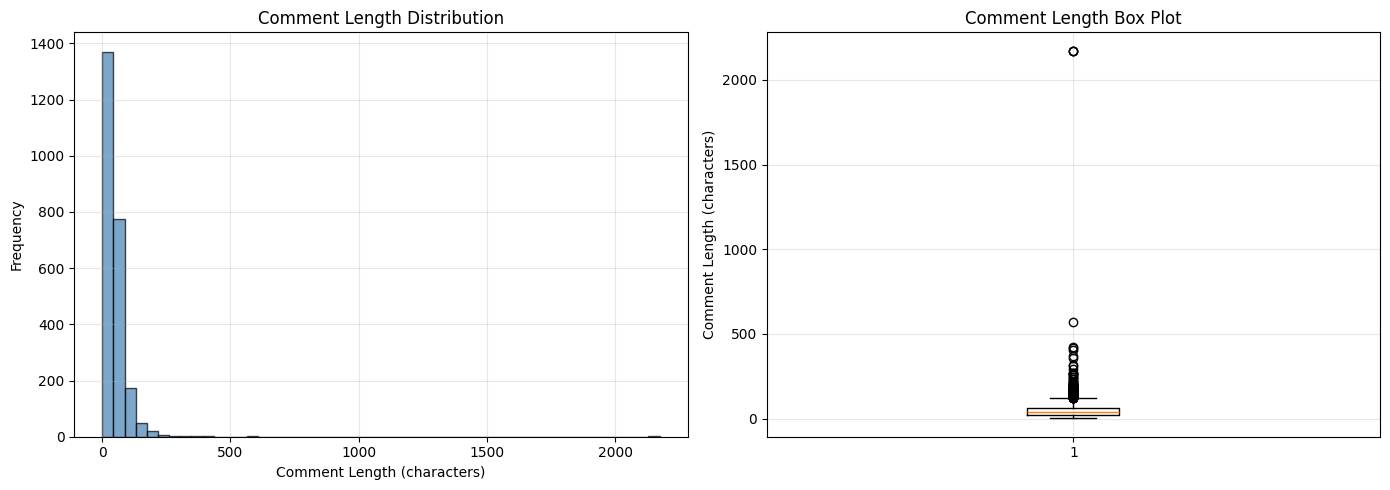

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['comment_length'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Comment Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Comment Length Distribution')
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df['comment_length'], vert=True)
axes[1].set_ylabel('Comment Length (characters)')
axes[1].set_title('Comment Length Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.3 Word Cloud - Before Preprocessing

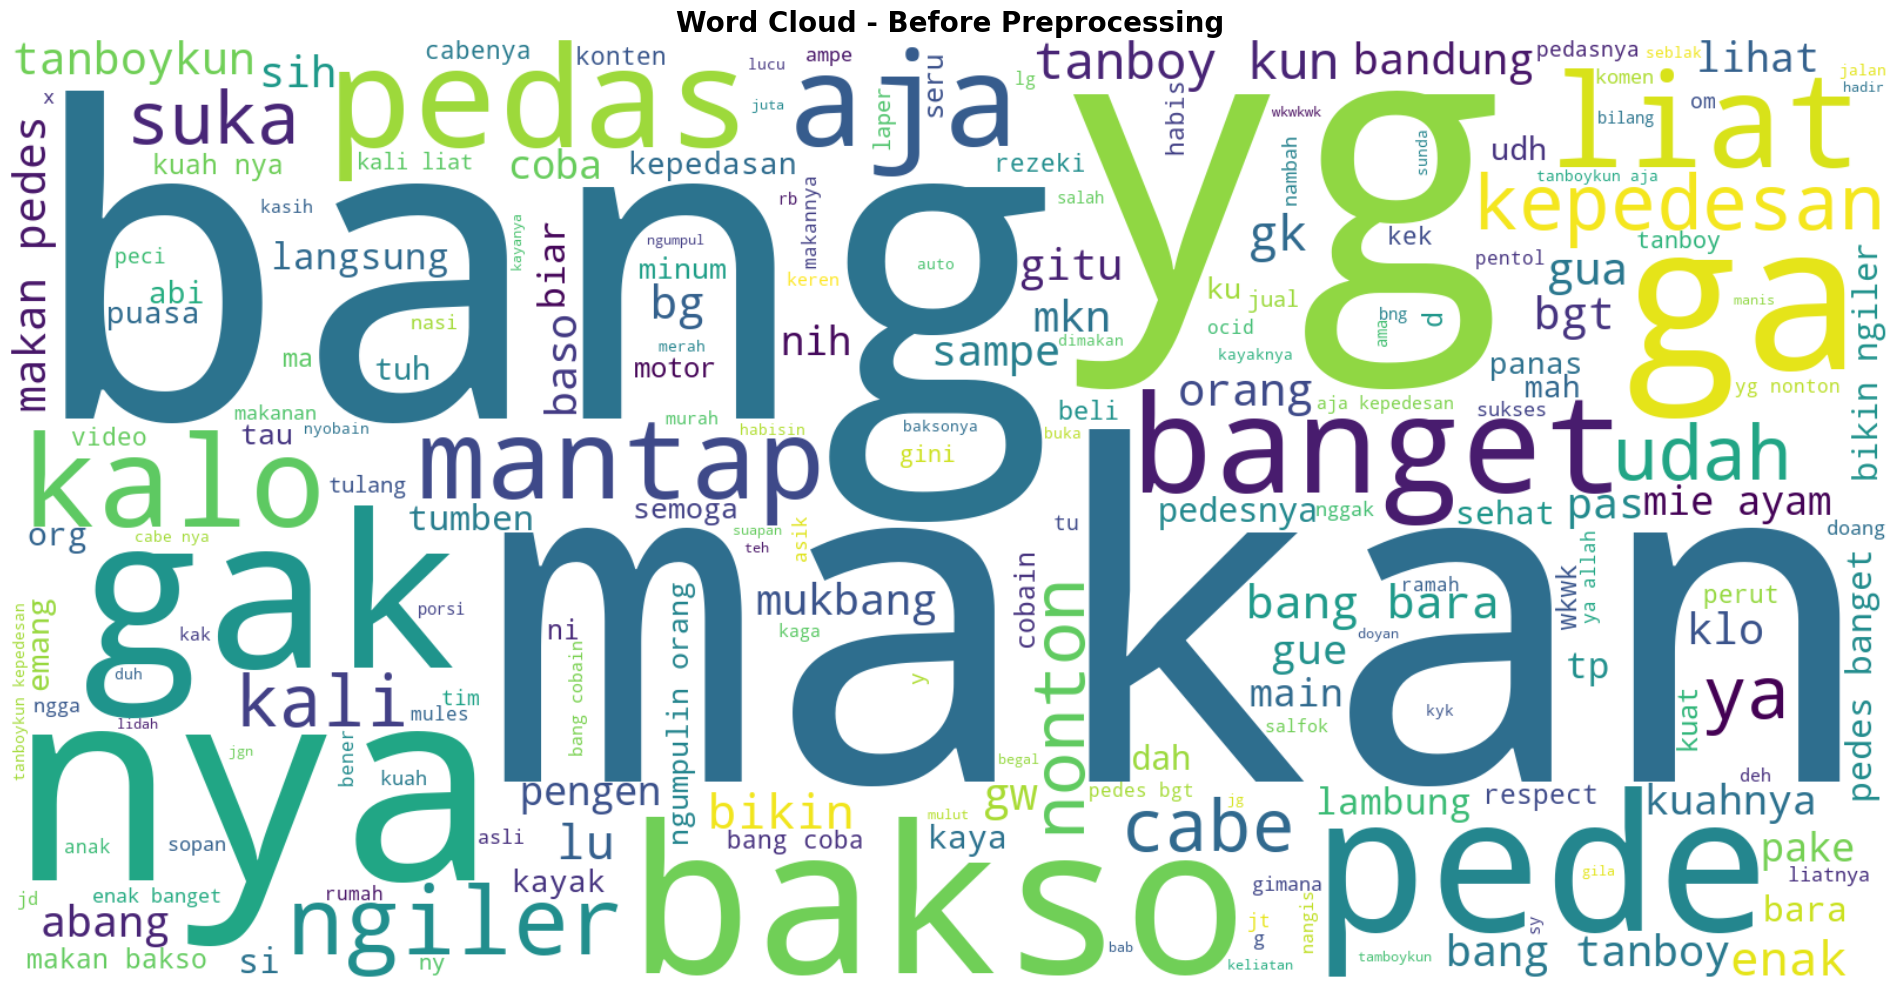

In [7]:
stopwords_id = set(stopwords.words('indonesian'))

text = ' '.join(df['Comment'].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text).lower()
words = [w for w in text.split() if w not in stopwords_id]
text_cleaned = ' '.join(words)

wc = WordCloud(
    max_words=WC_MAX_WORDS,
    width=1600,
    height=800,
    background_color='white',
    colormap='viridis'
).generate(text_cleaned)

plt.figure(figsize=WC_FIGSIZE)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Before Preprocessing', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.4 Top Word Frequencies - Before Preprocessing

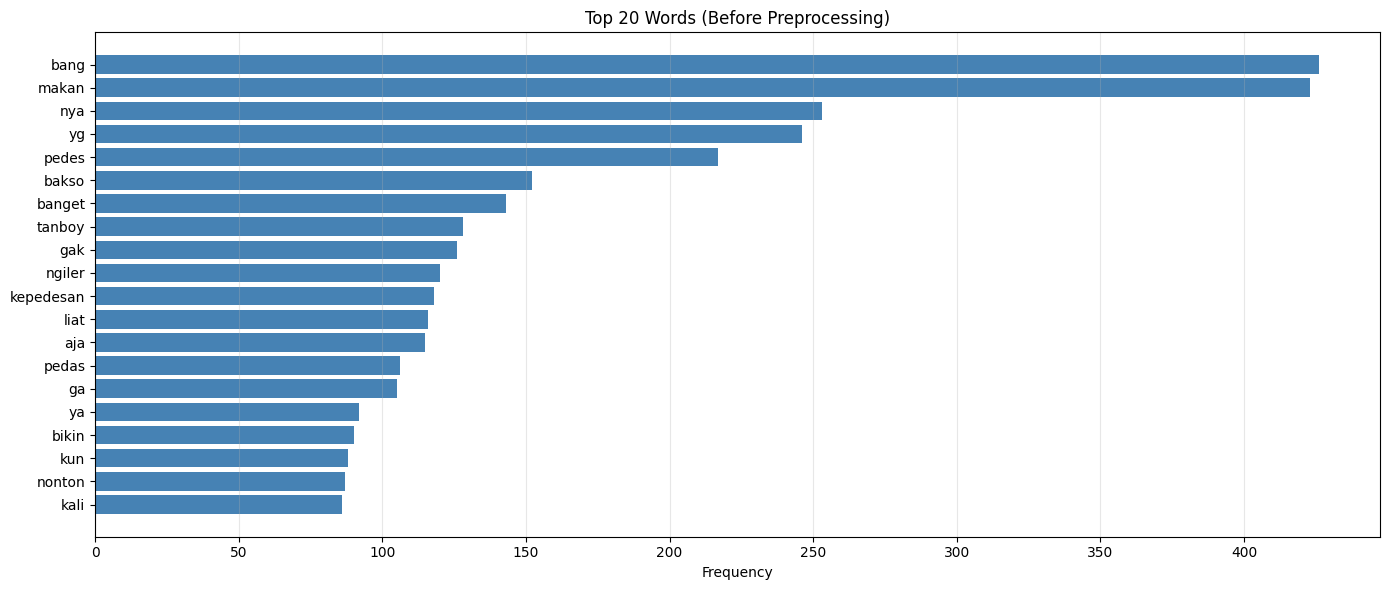


Top 20 words:
  bang: 426
  makan: 423
  nya: 253
  yg: 246
  pedes: 217
  bakso: 152
  banget: 143
  tanboy: 128
  gak: 126
  ngiler: 120
  kepedesan: 118
  liat: 116
  aja: 115
  pedas: 106
  ga: 105
  ya: 92
  bikin: 90
  kun: 88
  nonton: 87
  kali: 86


In [8]:
word_freq = Counter(words)
top_20 = word_freq.most_common(20)

words_list, counts = zip(*top_20)

plt.figure(figsize=(14, 6))
plt.barh(range(len(words_list)), counts, color='steelblue')
plt.yticks(range(len(words_list)), words_list)
plt.xlabel('Frequency')
plt.title('Top 20 Words (Before Preprocessing)')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 20 words:")
for word, count in top_20:
    print(f"  {word}: {count}")

## 🧹 3. Preprocessing

### 3.1 Remove Duplicates

In [9]:
df_original_len = len(df)
df = df.drop_duplicates(subset=['Comment']).reset_index(drop=True)
print(f"Duplicates removed: {df_original_len - len(df)}")
print(f"Remaining: {len(df)} comments")

Duplicates removed: 58
Remaining: 2353 comments


### 3.2 Load Slang Dictionaries

In [10]:
# Dictionary 1: louisowen6
url1 = 'https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt'
resp1 = requests.get(url1)
mapper_dict1 = json.loads(resp1.text)
print(f"Source 1: {len(mapper_dict1)} entries")

# Dictionary 2: okkyibrohim
url2 = 'https://raw.githubusercontent.com/okkyibrohim/id-abusive-language-detection/master/kamusalay.csv'
resp2 = requests.get(url2)
mapper_dict2 = {}
for line in resp2.text.splitlines():
    if line:
        parts = line.split(',', 1)
        if len(parts) == 2:
            mapper_dict2[parts[0]] = parts[1]
print(f"Source 2: {len(mapper_dict2)} entries")

# Dictionary 3: nasalsabila (Best - IEEE published)
url3 = 'https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv'
resp3 = requests.get(url3)
mapper_dict3 = {}
for line in resp3.text.splitlines()[1:]:
    if line:
        parts = line.split(',')
        if len(parts) >= 2:
            slang, formal = parts[0].strip(), parts[1].strip()
            if slang and formal:
                mapper_dict3[slang] = formal
print(f"Source 3: {len(mapper_dict3)} entries (Colloquial Indonesian Lexicon)")

# Dictionary 4: Manual additions
mapper_dict4 = {
    'yg': 'yang', 'dgn': 'dengan', 'utk': 'untuk', 'tdk': 'tidak',
    'hrs': 'harus', 'udh': 'sudah', 'udah': 'sudah', 'blm': 'belum',
    'blom': 'belum', 'krn': 'karena', 'karna': 'karena', 'jd': 'jadi',
    'jg': 'juga', 'gmn': 'bagaimana', 'gimana': 'bagaimana', 'knp': 'kenapa',
    'emg': 'memang', 'emang': 'memang', 'klo': 'kalau', 'kalo': 'kalau',
    'bgt': 'banget', 'bener': 'benar', 'bnr': 'benar', 'sgt': 'sangat',
    'tp': 'tapi', 'tpi': 'tapi', 'sm': 'sama', 'aja': 'saja', 'aj': 'saja',
    'lg': 'lagi', 'skrg': 'sekarang', 'skrng': 'sekarang', 'org': 'orang',
    'bs': 'bisa', 'sya': 'saya', 'gw': 'saya', 'gua': 'saya', 'gue': 'saya',
    'w': 'saya', 'ane': 'saya', 'km': 'kamu', 'lu': 'kamu', 'lo': 'kamu',
    'u': 'kamu', 'ga': 'tidak', 'gak': 'tidak', 'ngga': 'tidak', 
    'nggak': 'tidak', 'ntr': 'nanti', 'tar': 'nanti', 'bsk': 'besok', 'spil':'ungkap',
    'spill':'ungkap', 'take':'ambil', 'yagesya':'ya', 'enah':'entah', 'entah':'bingung',
    'masil':'masih', 'masi':'masih', 'smpe':'sampai', 'smp':'sampai', 'kaliya':'ya', 'anjg':'anjing',
    'xangat':'sangat', 'yanh':'yang', 'kocag':'kocak'
}
print(f"Source 4: {len(mapper_dict4)} entries (Manual)")

# Combine (Priority: manual > nasalsabila > okkyibrohim > louisowen)
slang_map = {**mapper_dict1, **mapper_dict2, **mapper_dict3, **mapper_dict4}
print(f"\n Total dictionary: {len(slang_map)} unique entries")

# Compile regex
slang_pattern = re.compile(
    r"\b(" + "|".join(re.escape(s) for s in slang_map.keys()) + r")\b",
    flags=re.IGNORECASE
)

print("\nSample slang mappings:")
print(list(slang_map.items())[:10])

Source 1: 1018 entries
Source 2: 237 entries
Source 3: 4338 entries (Colloquial Indonesian Lexicon)
Source 4: 66 entries (Manual)

 Total dictionary: 5176 unique entries

Sample slang mappings:
[('@', 'di'), ('abis', 'habis'), ('ad', 'ada'), ('adlh', 'adalah'), ('afaik', 'as far as i know'), ('ahaha', 'haha'), ('aj', 'saja'), ('ajep-ajep', 'dunia gemerlap'), ('ak', 'aku'), ('akika', 'aku')]


### 3.3 Text Cleaning Function

In [11]:
def clean_text(text): # IndoBERTweet style
    """
    Clean text with minimal, HuggingFace-style preprocessing:
    - decode HTML, remove HTML tags
    - convert URLs -> HTTPURL
    - convert mentions -> @USER
    - convert emojis/emoticons -> textual names via emoji.demojize
    - merge 'ikan nya' -> 'ikannya'
    - normalize possessive "wendy's" -> "wendys"
    - remove non-alnum chars, normalize whitespace, lowercase
    """
    if text is None:
        return ""

    # decode HTML entities and remove tags
    text = html.unescape(str(text))
    text = re.sub(r'<[^>]+>', ' ', text)

    # replace URLs with placeholder
    text = re.sub(r'https?://\S+', 'HTTPURL', text, flags=re.IGNORECASE)
    text = re.sub(r'www\.\S+', 'HTTPURL', text, flags=re.IGNORECASE)

    # replace mentions with placeholder
    text = re.sub(r'@\w+', '@USER', text)

    # remove hashtags symbol but keep the tag text (optional: keep as original removed)
    text = re.sub(r'#\w+', '', text)

    # convert emoji to textual names, e.g. "😊" -> ":smiling_face:" -> "smiling_face"
    try:
        dem = emoji.demojize(text)
        dem = re.sub(r':([A-Za-z0-9_\-\+]+):', r' \1 ', dem)  # keep the name words
        text = dem
    except Exception:
        pass

    # merge "ikan nya" -> "ikannya"
    text = re.sub(r'\b([A-Za-z]+)\s+(nya)\b', r'\1\2', text, flags=re.IGNORECASE)

    # normalize possessives (wendy's -> wendys), handle curly apostrophe too
    text = re.sub(r"\b([A-Za-z]+)'s\b", r"\1s", text)
    text = re.sub(r"\b([A-Za-z]+)’s\b", r"\1s", text)

    # keep only letters, numbers and spaces
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)

    # normalize whitespace and lowercase
    text = re.sub(r'\s+', ' ', text).strip().lower()

    return text


df['cleaned_text'] = df['Comment'].apply(clean_text)
print("Text cleaned")

Text cleaned


### 3.4 Slang Normalization

In [12]:
def normalize_slang(text):
    """Replace slang with formal Indonesian"""
    return slang_pattern.sub(
        lambda m: slang_map.get(m.group(0).lower(), m.group(0)),
        text.lower()
    )

df['slang_corrected'] = df['cleaned_text'].apply(normalize_slang)
print("Slang normalized")

Slang normalized


### 3.5 Tokenization

In [13]:
df['tokenized'] = df['slang_corrected'].apply(word_tokenize)
print(" Tokenized")

 Tokenized


### 3.6 Stopword Removal

In [14]:
stopwords_id = set(stopwords.words('indonesian'))
df['stopwords_removed'] = df['tokenized'].apply(
    lambda tokens: [w for w in tokens if w not in stopwords_id]
)
print(" Stopwords removed")

 Stopwords removed


### 3.7 Stemming

In [15]:
stemmer = MPStemmer()
df['stemmed_text'] = df['stopwords_removed'].apply(
    lambda tokens: " ".join([stemmer.stem(w) for w in tokens])
)
print(" Stemming complete")

 Stemming complete


### 3.8 Final Quality Filter

In [16]:
# 1) HAPUS baris kosong setelah cleaning (emoji-only, whitespace)
initial_len = len(df)
# Pastikan kita menghapus baris dimana cleaned_text kosong/NaN
df = df[df['cleaned_text'].fillna('').astype(str).str.strip().astype(bool)].reset_index(drop=True)
print(f" Removed empty cleaned_text rows: {initial_len - len(df)} rows removed. Remaining = {len(df)}")

# 2) Generic reaction words to detect low-value comments
GENERIC_WORDS = {
    'mantap', 'keren', 'gokil', 'nice', 'good', 'terbaik', 'best', 
    'juara', 'gacor', 'jos', 'top', 'markotop', 'ok', 'oke', 'sip',
    'siap', 'nyimak', 'hadir', 'absen', 'first', 'pertamax', 'view',
    'like', 'subs', 'subscribe', 'mampir', 'jejak', 'nitip', 'promo',
    'ganteng', 'cantik', 'bang', 'kak', 'mas', 'om', 'gan', 'min',
    'wkwk', 'haha', 'hihi', 'wkwkwk', 'awokwok',
    'info', 'infokan', 'gas', 'lanjut', 'part', 'semangat',
    'mantap👍', 'mantap🙂', 'bgt', 'banget', 'sih', 'dong', 'kan', 'nya', 'yg'
}
# normalize generic words to lowercase (safety)
GENERIC_WORDS = set(w.lower() for w in GENERIC_WORDS)

# simple token cleaning helper
PUNCT_RE = re.compile(r'^[^\w]+|[^\w]+$')

def tokenize_simple(text):
    toks = [PUNCT_RE.sub('', t).lower() for t in str(text).split() if PUNCT_RE.sub('', t)]
    return toks

def is_high_quality(text, min_words=3, unique_ratio_thresh=0.2, min_non_generic=2):
    """
    Return True if text passes heuristics for being informative:
      - at least min_words tokens
      - not dominated by repeating single token (unique_ratio)
      - contains at least min_non_generic tokens that are not in GENERIC_WORDS
    """
    if not isinstance(text, str):
        return False
    toks = tokenize_simple(text)
    n = len(toks)
    if n == 0:
        return False
    
    # Filter A: too short in token count
    # Contoh: "Mahal" (1 kata) -> False
    if n < min_words:
        return False
        
    # Filter B: repetition / spam (unique token ratio)
    # Contoh: "ganteng ganteng ganteng" (Ratio 0.33) -> False jika threshold 0.2 ketat, tapi aman di sini
    uniq_ratio = len(set(toks)) / n
    if uniq_ratio < unique_ratio_thresh:
        return False
        
    # Filter C: generic-only content (Anti-Mantap)
    # Contoh: "Mantap bang keren" -> Non-generic: 0 -> False
    # Contoh: "Mantap bang baterai awet" -> Non-generic: 2 ("baterai", "awet") -> True
    non_generic = [t for t in toks if t not in GENERIC_WORDS]
    if len(non_generic) < min_non_generic:
        return False
        
    # Passed all checks -> consider high-quality
    return True

# 3) Apply filter with conservative defaults
MIN_WORDS = 3
UNIQUE_RATIO_THRESH = 0.2
MIN_NON_GENERIC = 2 # Minimal ada 2 kata yang BUKAN kata generic

mask_quality = df['cleaned_text'].apply(lambda x: is_high_quality(x, 
                                                                 min_words=MIN_WORDS,
                                                                 unique_ratio_thresh=UNIQUE_RATIO_THRESH,
                                                                 min_non_generic=MIN_NON_GENERIC))

n_before = len(df)
df_filtered = df[mask_quality].reset_index(drop=True)
n_after = len(df_filtered)

print(f"\nSpam/Generic Filtering Report:")
print(f"Removed: {n_before - n_after} rows")
print(f"Remaining: {n_after} rows ({n_after / n_before:.1%} retained)")

# 4) Show quick samples for verification
n_show = 6
print("\nSample KEPT (High Quality):")
if not df_filtered.empty:
    display(df_filtered[['Comment', 'cleaned_text']].sample(min(n_show, len(df_filtered)), random_state=42))

print("\nSample REMOVED (Low Quality/Spam):")
removed = df[~mask_quality].reset_index(drop=True)
if not removed.empty:
    display(removed[['Comment', 'cleaned_text']].sample(min(n_show, len(removed)), random_state=42))

# 5) TIMPA DF UTAMA
df = df_filtered.copy()

 Removed empty cleaned_text rows: 4 rows removed. Remaining = 2349

Spam/Generic Filtering Report:
Removed: 200 rows
Remaining: 2149 rows (91.5% retained)

Sample KEPT (High Quality):


,Comment,cleaned_text
1159,Gigi depan kok kayak copot bang,gigi depan kok kayak copot bang
1822,Buset yg jual make bahasa jaksel🤣🤣,buset yg jual make bahasa jaksel rolling on the floor laughing rolling on the floor laughing
978,"Bisa battle ini mah euy kalo makan pentol begal aja tamboykun kewalahan :,)",bisa battle ini mah euy kalo makan pentol begal aja tamboykun kewalahan
759,5:25 team yang langsung skip loncaaatt....yang kesel karena cuplikan di awal😅,5 25 team yang langsung skip loncaaatt yang kesel karena cuplikan di awal grinning face with sweat
874,"Duh enak ny liat Abang mkn ..,jadi pingin mkn jg aku😂",duh enak ny liat abang mkn jadi pingin mkn jg aku face with tears of joy
109,MY BODYGINNN DRYING GIMNY GIMME GIMME AREK AREKA BAMDUNG ANEKAAAAA YESSSSSSS,my bodyginnn drying gimny gimme gimme arek areka bamdung anekaaaaa yesssssss



Sample REMOVED (Low Quality/Spam):


,Comment,cleaned_text
95,14:23,14 23
15,Ngiler doang,ngiler doang
30,Ngiler liatnya,ngiler liatnya
158,Absennnn 🔥,absennnn fire
128,tanboykun ahegao,tanboykun ahegao
115,ngilerrrrrrr,ngilerrrrrrr


### Final Data

In [17]:
# Prepare BERT text
df['bert_text'] = df['slang_corrected']

# Final columns
columns_to_keep = ['Comment', 'bert_text',
                   'stemmed_text', 'comment_length']
df = df[columns_to_keep].copy()

# Preview
print("\nSample processed data:")
df.sample(10)


Sample processed data:


,Comment,bert_text,stemmed_text,comment_length
1373,throwback dong bang makan richeese level 5 lagi,throwback dong bang makan richeese level 5 lagi,throwback bang makan richeese level 5,47
1133,Ini bukan tanboy Kun yang ku kenal😢,ini bukan tanboy kun yang ku kenal crying face,tanboy kun ku kenal crying face,35
405,eh aya a ocid 😅,eh aya a ocid grinning face with sweat,eh aya a ocid grinning face with sweat,15
785,kapan lagi liat abg tanboy langsung kepedesan😂😅,kapan lagi lihat abang tanboy langsung kepedesan face with tears of joy grinning face with sweat,lihat abang tanboy langsung pedas face with tears of joy grinning face with sweat,47
1843,MUMPUNG LAGI DI BANDUNG COBAIN AYAM GORENG MAMAH IRWAN DI KOPO BANG,selagi lagi di bandung mencoba ayam goreng mamah irwan di kopo bang,selagi bandung coba ayam goreng mamah irwan kopo bang,67
239,"Mauuu ini belom kelakon aja 😢,,,pdhl kemarin k bandung malah lupa",mau ini belum kelakon saja crying face padahal kemarin ke bandung bahkan lupa,lakon crying face kemarin bandung lupa,65
1268,Pengen sukses macam Abang 🙏,pengin sukses macam abang folded hands,pengin sukses abang folded hands,27
941,Cuaca hujan cocok banget nihhh🤤🤤,cuaca hujan cocok banget nih drooling face drooling face,cuaca hujan cocok banget ini drooling face drooling face,32
608,Yang nonton sampe nelen meja ☝️,yang menonton sampai nelen meja index pointing up,tonton menelen meja index pointing up,31
1499,bang tanboy kun coba sate maranggi yang ada di bandung,bang tanboy kun coba sate maranggi yang ada di bandung,bang tanboy kun coba sate maranggi bandung,54


## 📊 4. EDA After Preprocessing

### 4.1 Word Cloud - After Preprocessing

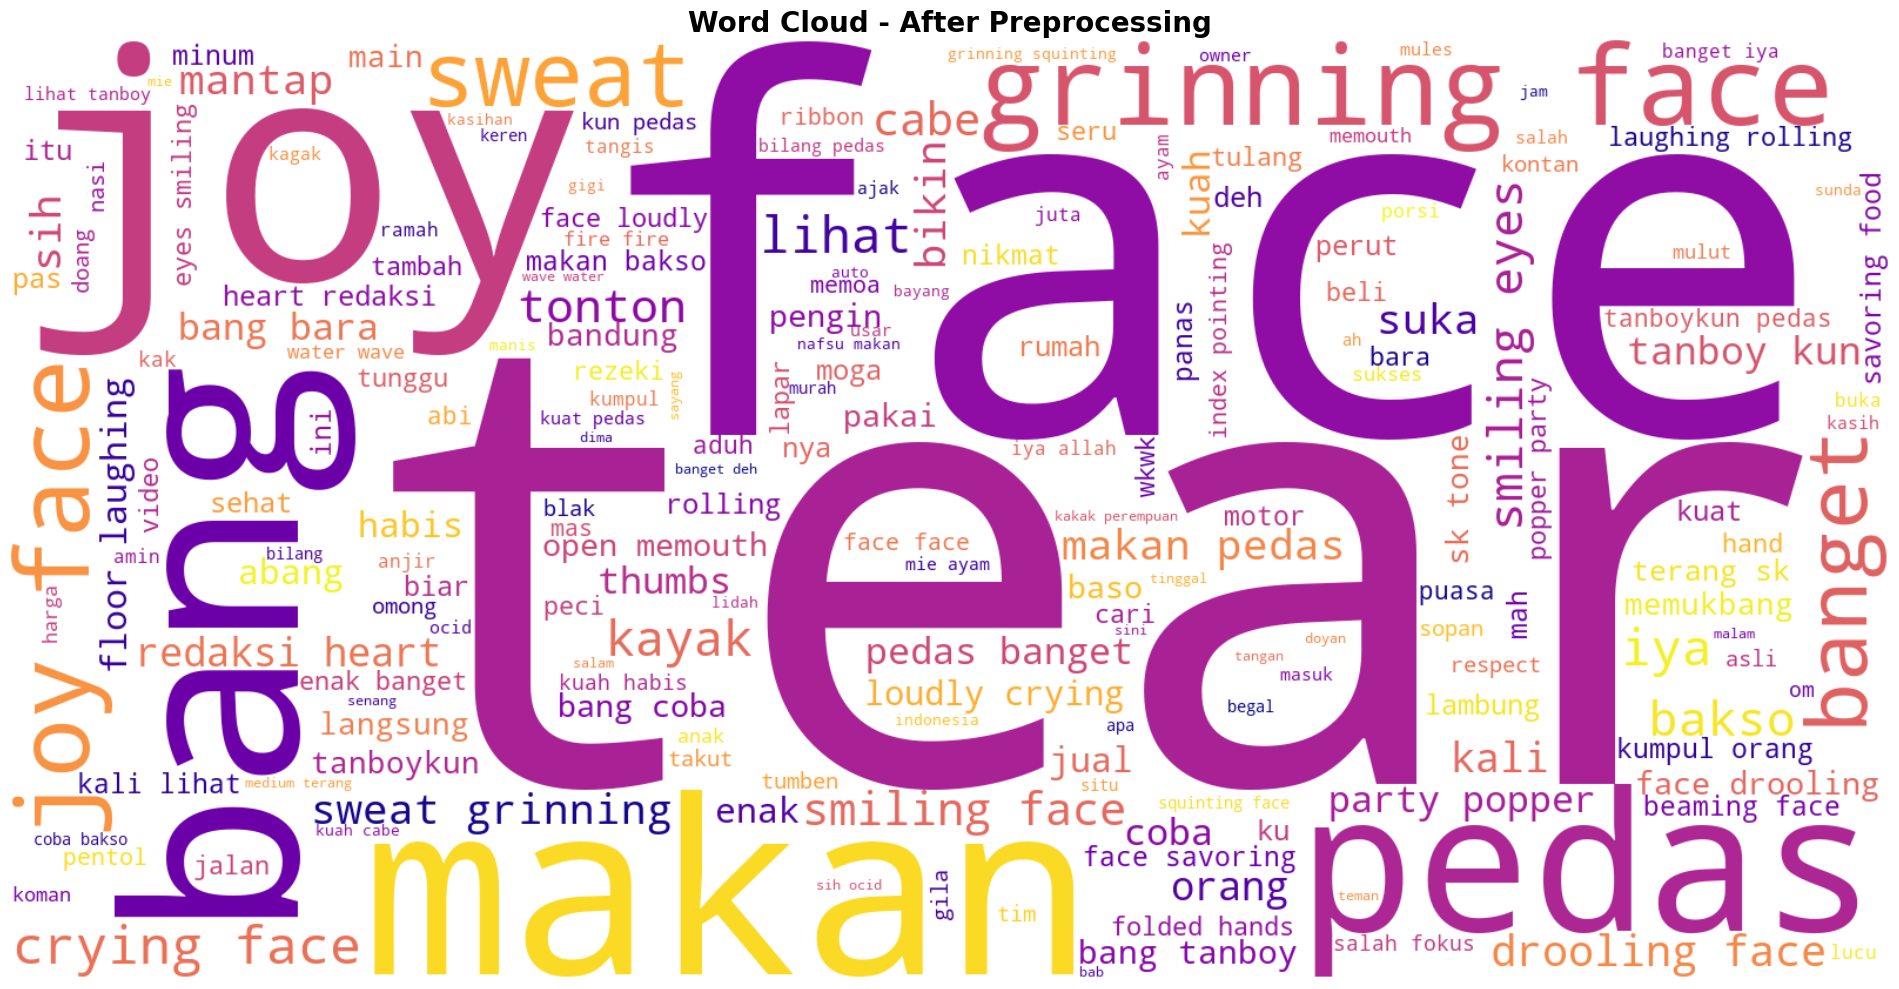

In [18]:
processed_text = ' '.join(df['stemmed_text'].astype(str).tolist())

wc_processed = WordCloud(
    max_words=WC_MAX_WORDS,
    width=1600,
    height=800,
    background_color='white',
    colormap='plasma'
).generate(processed_text)

plt.figure(figsize=WC_FIGSIZE)
plt.imshow(wc_processed, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - After Preprocessing', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.2 Top Word Frequencies - After Preprocessing

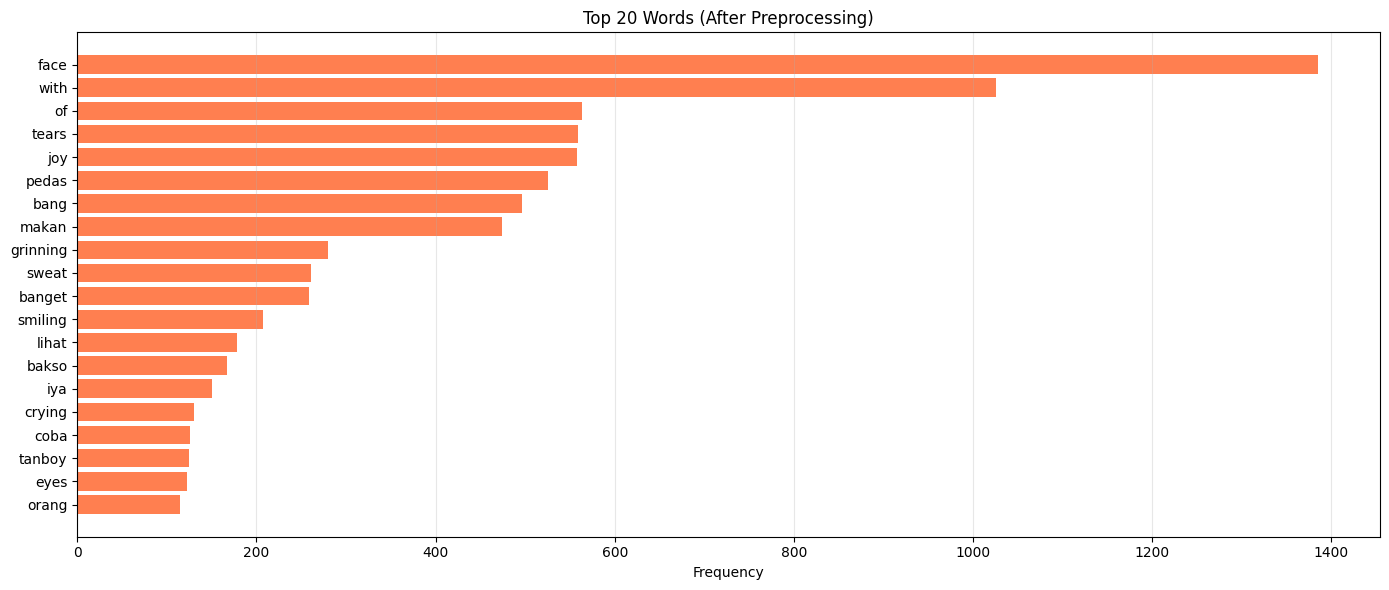


Top 20 stemmed words:
  face: 1385
  with: 1026
  of: 563
  tears: 559
  joy: 558
  pedas: 525
  bang: 496
  makan: 474
  grinning: 280
  sweat: 261
  banget: 259
  smiling: 207
  lihat: 178
  bakso: 167
  iya: 151
  crying: 130
  coba: 126
  tanboy: 125
  eyes: 123
  orang: 115


In [19]:
words_processed = processed_text.split()
word_freq_processed = Counter(words_processed)
top_20_processed = word_freq_processed.most_common(20)

words_list, counts = zip(*top_20_processed)

plt.figure(figsize=(14, 6))
plt.barh(range(len(words_list)), counts, color='coral')
plt.yticks(range(len(words_list)), words_list)
plt.xlabel('Frequency')
plt.title('Top 20 Words (After Preprocessing)')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 20 stemmed words:")
for word, count in top_20_processed:
    print(f"  {word}: {count}")

## 🎯 5. Pipeline 1: TF-IDF + K-Means Clustering

### 5.1 TF-IDF Vectorization

In [20]:
# Clustering Parameters
KMEANS_K_RANGE = range(5, 50)  # Test K from 5 to 50
HDBSCAN_MIN_CLUSTER_SIZE = 10

# UMAP Parameters (for BERT dimensionality reduction)
UMAP_N_NEIGHBORS = 15
UMAP_N_COMPONENTS = 5
UMAP_MIN_DIST = 0.0

# TF-IDF Parameters
TFIDF_MAX_FEATURES = 5000

# BERT Parameters
BERT_MODEL = 'indolem/indobertweet-base-uncased'

# Configuration for SeaLLM
LLM_MODEL_ID = "SeaLLMs/SeaLLMs-v3-7B-Chat"

# Representative Sampling
MIN_SAMPLES = 5
MAX_SAMPLES = 20  # Cap this to fit SeaLLM context window (approx 500-800 tokens)
SAMPLE_RATIO = 0.1 # Take top 10% of the cluster

In [21]:
vectorizer_tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES)
X_tfidf = vectorizer_tfidf.fit_transform(df['stemmed_text'])

print(f"TF-IDF matrix: {X_tfidf.shape}")
print(f"Documents: {X_tfidf.shape[0]}")
print(f"Features: {X_tfidf.shape[1]}")

TF-IDF matrix: (2149, 3195)
Documents: 2149
Features: 3195


### 5.2 Best Silhouette Method for Optimal K

Testing K values: 100%|██████████| 45/45 [00:20<00:00,  2.25it/s]


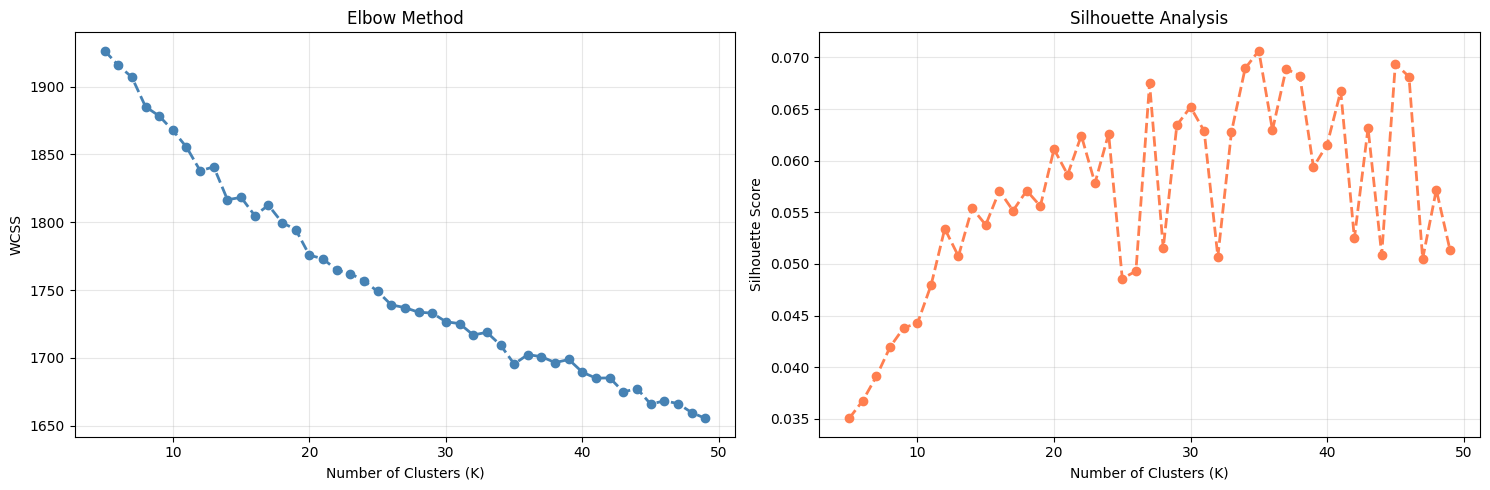


Optimal K: 35 (silhouette: 0.0707)


In [22]:
wcss = []
silhouette_scores = []

for k in tqdm(KMEANS_K_RANGE, desc="Testing K values"):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_tfidf)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_tfidf, kmeans.labels_))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(KMEANS_K_RANGE, wcss, marker='o', linestyle='--', color='steelblue', linewidth=2)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('WCSS')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

ax2.plot(KMEANS_K_RANGE, silhouette_scores, marker='o', linestyle='--', color='coral', linewidth=2)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k = list(KMEANS_K_RANGE)[silhouette_scores.index(max(silhouette_scores))]
print(f"\nOptimal K: {optimal_k} (silhouette: {max(silhouette_scores):.4f})")

### 5.3 K-Means Clustering

In [23]:
kmeans_model = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df['cluster_tfidf'] = kmeans_model.fit_predict(X_tfidf)

print(f"Clustering complete with K={optimal_k}")
print("\nCluster distribution:")
for i in range(optimal_k):
    count = np.sum(df['cluster_tfidf'] == i)
    pct = (count / len(df)) * 100
    print(f"  Cluster {i}: {count:4d} comments ({pct:5.2f}%)")

Clustering complete with K=35

Cluster distribution:
  Cluster 0:   15 comments ( 0.70%)
  Cluster 1:   80 comments ( 3.72%)
  Cluster 2:  491 comments (22.85%)
  Cluster 3:   15 comments ( 0.70%)
  Cluster 4:   83 comments ( 3.86%)
  Cluster 5:  280 comments (13.03%)
  Cluster 6:   35 comments ( 1.63%)
  Cluster 7:  136 comments ( 6.33%)
  Cluster 8:   45 comments ( 2.09%)
  Cluster 9:   38 comments ( 1.77%)
  Cluster 10:   30 comments ( 1.40%)
  Cluster 11:   63 comments ( 2.93%)
  Cluster 12:   31 comments ( 1.44%)
  Cluster 13:   59 comments ( 2.75%)
  Cluster 14:  116 comments ( 5.40%)
  Cluster 15:    9 comments ( 0.42%)
  Cluster 16:   22 comments ( 1.02%)
  Cluster 17:   34 comments ( 1.58%)
  Cluster 18:    5 comments ( 0.23%)
  Cluster 19:   16 comments ( 0.74%)
  Cluster 20:  110 comments ( 5.12%)
  Cluster 21:   47 comments ( 2.19%)
  Cluster 22:   22 comments ( 1.02%)
  Cluster 23:   25 comments ( 1.16%)
  Cluster 24:   52 comments ( 2.42%)
  Cluster 25:   20 comments ( 0.

### 5.4 Cluster Interpretation (Top Keywords)

In [24]:
feature_names = vectorizer_tfidf.get_feature_names_out()
cluster_keywords_tfidf = {}

for i in range(optimal_k):
    centroid = kmeans_model.cluster_centers_[i]
    top_indices = centroid.argsort()[-10:][::-1]
    keywords = [feature_names[j] for j in top_indices]
    cluster_keywords_tfidf[i] = keywords
    
    print(f"Cluster {i}: {', '.join(keywords[:5])}")

Cluster 0: ini, pagi, november, orang, gercap
Cluster 1: smiling, eyes, with, face, beaming
Cluster 2: banget, face, tonton, sih, cabe
Cluster 3: minum, kuah, bang, pedas, anjir
Cluster 4: pedas, banget, enak, tanboykun, kali
Cluster 5: joy, tears, of, with, face
Cluster 6: bikin, main, pedas, tagih, banget
Cluster 7: sweat, grinning, with, face, pedas
Cluster 8: bakso, makan, tukang, sih, bang
Cluster 9: bandung, sopan, orang, adab, banget
Cluster 10: drooling, face, banget, makan, bakso
Cluster 11: crying, loudly, face, banget, pedas
Cluster 12: kumpul, orang, suka, tonton, koman
Cluster 13: lihat, pedas, bang, makan, tanboy
Cluster 14: makan, pedas, bang, cabe, kayak
Cluster 15: mules, makan, udahannya, lngsng, wow
Cluster 16: redaksi, heart, bang, mantap, face
Cluster 17: begal, pentol, ceker, bakso, mantap
Cluster 18: wave, water, mulut, tonton, liur
Cluster 19: gaco, level, bang, mie, coba
Cluster 20: bang, bara, memukbang, makan, kali
Cluster 21: kun, tanboy, makan, pedas, lihat

### 5.5 Cluster Distribution Visualization

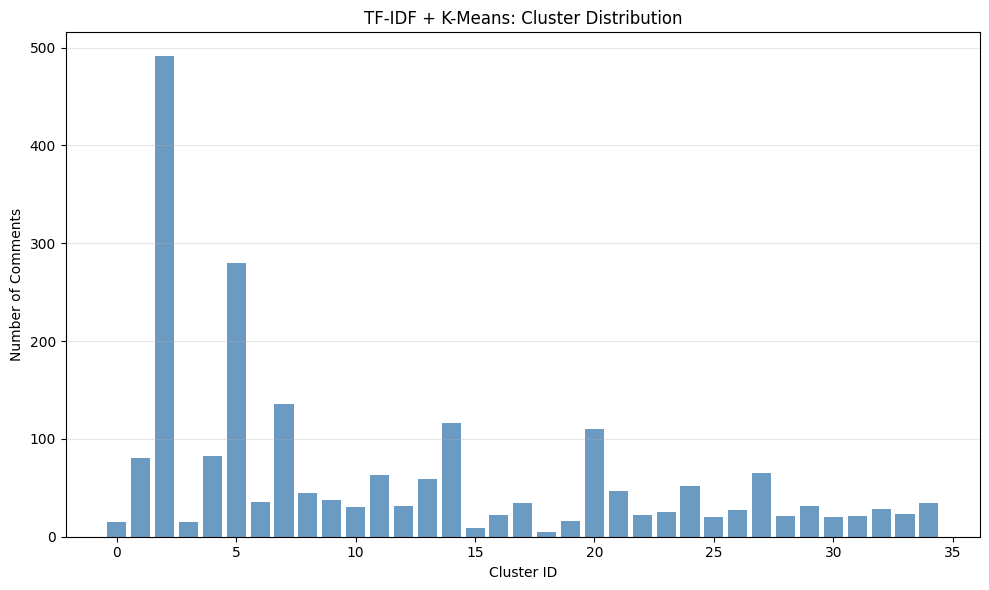

In [25]:
plt.figure(figsize=(10, 6))
cluster_counts = df['cluster_tfidf'].value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values, color='steelblue', alpha=0.8)
plt.xlabel('Cluster ID')
plt.ylabel('Number of Comments')
plt.title('TF-IDF + K-Means: Cluster Distribution')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 🎯 6. Pipeline 2: BERT + UMAP + HDBSCAN Clustering

### 6.1 Load BERT Model

In [26]:
tokenizer_bert = AutoTokenizer.from_pretrained(BERT_MODEL)
model_bert = AutoModel.from_pretrained(BERT_MODEL)
model_bert.to(device)
model_bert.eval()
print(f" BERT loaded on {device}")

 BERT loaded on cuda


### 6.2 Extract BERT Embeddings

In [27]:
def get_bert_embeddings(texts, tokenizer, model,
                        batch_size: int = 32,
                        max_length: int = 128,
                        pooling: str = "mean",   # "mean" (recommended) or "cls"
                        l2_normalize: bool = True,
                        show_progress: bool = True):
    
    model = model.to(device)
    model.eval()
    all_embs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="BERT embeddings", disable=not show_progress):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors="pt", padding="longest",
                        truncation=True, max_length=max_length)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc, return_dict=True)
        last_hidden = out.last_hidden_state  # (b, seq_len, dim)
        if pooling == "cls":
            emb = last_hidden[:, 0, :].cpu().numpy()
        else:
            attn = enc.get("attention_mask", None)
            if attn is None:
                emb = last_hidden.mean(dim=1).cpu().numpy()
            else:
                mask = attn.unsqueeze(-1)
                summed = (last_hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1)
                emb = (summed / counts).cpu().numpy()
        all_embs.append(emb.astype(np.float32))
    X = np.vstack(all_embs) if len(all_embs) > 0 else np.zeros((0, model.config.hidden_size), dtype=np.float32)
    if l2_normalize and X.shape[0] > 0:
        X = normalize(X, norm="l2", axis=1).astype(np.float32)
    return X

texts = df['bert_text'].fillna("").astype(str).tolist()
X_bert = get_bert_embeddings(texts, tokenizer_bert, model_bert, batch_size=32, max_length=128, pooling="mean", l2_normalize=True)
print("X_bert shape:", X_bert.shape)

# Clear GPU memory
clear_gpu_memory()

BERT embeddings: 100%|██████████| 68/68 [00:01<00:00, 34.25it/s]


X_bert shape: (2149, 768)


### 6.3 UMAP Dimensionality Reduction

In [28]:
print(f"Reducing 768 dims → {UMAP_N_COMPONENTS} dims")

umap_model = umap.UMAP(
    n_neighbors=UMAP_N_NEIGHBORS,
    n_components=UMAP_N_COMPONENTS,
    metric='cosine',
    min_dist=UMAP_MIN_DIST,
    random_state=42
)

X_bert_reduced = umap_model.fit_transform(X_bert)
print(f"Reduced shape: {X_bert_reduced.shape}")

Reducing 768 dims → 5 dims
Reduced shape: (2149, 5)


### 6.4 HDBSCAN Clustering

In [29]:
clusterer_hdbscan = hdbscan.HDBSCAN(
    metric='euclidean',
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    cluster_selection_method='eom'
)

df['cluster_bert'] = clusterer_hdbscan.fit_predict(X_bert_reduced)

# Statistics
label_counts = Counter(df['cluster_bert'])
n_clusters = len(label_counts) - (1 if -1 in label_counts else 0)
n_noise = label_counts.get(-1, 0)

print(f"Clusters: {n_clusters}")
print(f"Noise: {n_noise} ({(n_noise/len(df)*100):.2f}%)")

print("\nCluster distribution:")
for label in sorted(label_counts.keys()):
    count = label_counts[label]
    pct = (count / len(df)) * 100
    if label == -1:
        print(f"Noise: {count:4d} ({pct:5.2f}%)")
    else:
        print(f"Cluster {label}: {count:4d} ({pct:5.2f}%)")

Clusters: 44
Noise: 925 (43.04%)

Cluster distribution:
Noise:  925 (43.04%)
Cluster 0:   12 ( 0.56%)
Cluster 1:   18 ( 0.84%)
Cluster 2:   16 ( 0.74%)
Cluster 3:   17 ( 0.79%)
Cluster 4:   34 ( 1.58%)
Cluster 5:   21 ( 0.98%)
Cluster 6:   95 ( 4.42%)
Cluster 7:   12 ( 0.56%)
Cluster 8:   13 ( 0.60%)
Cluster 9:   21 ( 0.98%)
Cluster 10:   12 ( 0.56%)
Cluster 11:   15 ( 0.70%)
Cluster 12:   52 ( 2.42%)
Cluster 13:   14 ( 0.65%)
Cluster 14:   11 ( 0.51%)
Cluster 15:   16 ( 0.74%)
Cluster 16:   24 ( 1.12%)
Cluster 17:   18 ( 0.84%)
Cluster 18:   11 ( 0.51%)
Cluster 19:   17 ( 0.79%)
Cluster 20:   13 ( 0.60%)
Cluster 21:   10 ( 0.47%)
Cluster 22:   45 ( 2.09%)
Cluster 23:  103 ( 4.79%)
Cluster 24:   38 ( 1.77%)
Cluster 25:   10 ( 0.47%)
Cluster 26:   45 ( 2.09%)
Cluster 27:   29 ( 1.35%)
Cluster 28:   14 ( 0.65%)
Cluster 29:   14 ( 0.65%)
Cluster 30:   27 ( 1.26%)
Cluster 31:   54 ( 2.51%)
Cluster 32:   21 ( 0.98%)
Cluster 33:   17 ( 0.79%)
Cluster 34:   16 ( 0.74%)
Cluster 35:   20 ( 0.93

### 6.5 HDBSCAN Cluster Visualization

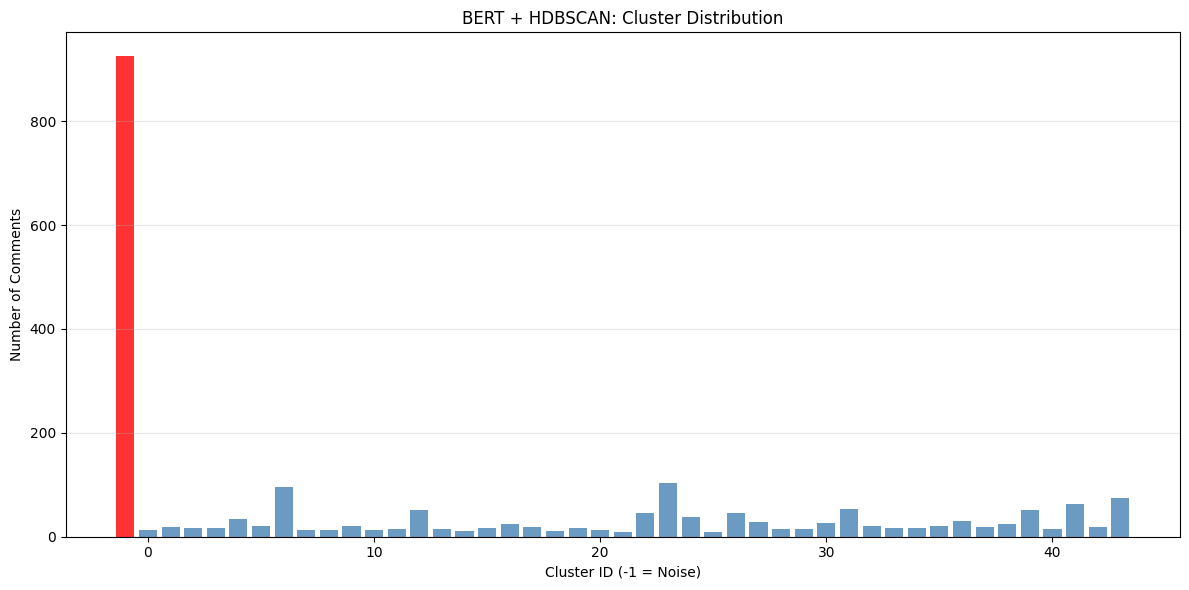

In [30]:
plt.figure(figsize=(12, 6))
cluster_counts_bert = df['cluster_bert'].value_counts().sort_index()
colors = ['red' if x == -1 else 'steelblue' for x in cluster_counts_bert.index]
plt.bar(cluster_counts_bert.index, cluster_counts_bert.values, color=colors, alpha=0.8)
plt.xlabel('Cluster ID (-1 = Noise)')
plt.ylabel('Number of Comments')
plt.title('BERT + HDBSCAN: Cluster Distribution')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 6.6 Extract BERT Cluster Keywords (c-TF-IDF)

In [31]:
# Prepare text column
df['text_for_keywords'] = df['bert_text']

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    """Class-based TF-IDF for keyword extraction"""
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w, where=w!=0)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t, where=sum_t!=0)).reshape(-1, 1)
    return np.multiply(tf, idf), count

# Group by cluster
docs_per_cluster = df[df['cluster_bert'] != -1].groupby(['cluster_bert'], as_index=False).agg(
    {'text_for_keywords': ' '.join}
)

# Calculate c-TF-IDF
tf_idf, count = c_tf_idf(docs_per_cluster['text_for_keywords'].values, m=len(df))
words = count.get_feature_names_out()

cluster_keywords_bert = {}
for i, label in enumerate(docs_per_cluster['cluster_bert'].values):
    indices = tf_idf[:, i].argsort()[-10:][::-1]
    keywords = [words[idx] for idx in indices]
    cluster_keywords_bert[label] = keywords
    print(f"Cluster {label}: {', '.join(keywords[:5])}")

print(" Keywords extracted")

Cluster 0: mana, daerah, lokasi, bandungnya, di
Cluster 1: ocid, aya, sih, memang, kata
Cluster 2: mah, sih, euy, ieu, wae
Cluster 3: juta, 276, harganya, masa, doang
Cluster 4: redaksi, heart, popper, party, mantap
Cluster 5: ribbon, panda, tropical, fish, hamster
Cluster 6: yang, makan, saya, dan, pedas
Cluster 7: pointing, index, backhand, down, up
Cluster 8: open, mouth, with, face, huh
Cluster 9: respect, motor, naik, abang, motornya
Cluster 10: semoga, clapping, sukses, hands, selalu
Cluster 11: dan, 09, bisa, bandung, ramah
Cluster 12: ngumpulin, mau, orang, yang, menonton
Cluster 13: peci, pecinya, fokus, salah, bapaknya
Cluster 14: ngilerrr, gimme, ngilerr, banget, ubar
Cluster 15: drooling, face, ngilerrr, jadi, enak
Cluster 16: crying, loudly, face, sparkles, folded
Cluster 17: banget, enak, mau, sumpah, wow
Cluster 18: crying, banget, pengin, lapar, lagi
Cluster 19: laughing, floor, on, rolling, the
Cluster 20: yang, saya, dia, makan, lu
Cluster 21: thumbs, up, blue, top, h

## 🔍 7. Representative Sampling

In [32]:
def calculate_n_samples(n_total):
    """
    Dynamically calculate N based on cluster size.
    Formula: 10% of cluster, but never less than 5 and never more than 20.
    """
    n = int(n_total * SAMPLE_RATIO)
    return max(MIN_SAMPLES, min(n, MAX_SAMPLES))

def get_diverse_representative_samples(
    df, 
    cluster_col, 
    embeddings, 
    diversity_weight=0.7,  # 0.7 = Focus on Relevance, 0.3 = Focus on Diversity
    min_length=20
):
    """
    Selects diverse samples using MMR (Maximal Marginal Relevance) + Adaptive Sizing.
    """
    samples = {}
    
    # Ensure embeddings are numpy array
    if hasattr(embeddings, "toarray"):
        embeddings = embeddings.toarray()

    for cid in sorted(df[cluster_col].unique()):
        if cid == -1: continue  # Skip noise
        
        # A. Get Cluster Data
        mask = df[cluster_col] == cid
        cluster_df = df[mask]
        cluster_indices = cluster_df.index.tolist()
        cluster_embs = embeddings[mask.values]
        
        # B. Calculate Adaptive Target N
        target_n = calculate_n_samples(len(cluster_indices))
        
        # C. Filter Candidates (Safety Check)
        # We prefer comments that are long enough to be meaningful
        valid_mask = [len(str(t)) >= min_length for t in cluster_df['bert_text']]
        
        # If filtering kills too many (below our target), revert to using ALL comments
        if sum(valid_mask) < target_n:
            candidates_idx = np.arange(len(cluster_df))
        else:
            candidates_idx = np.where(valid_mask)[0]
            
        candidate_embs = cluster_embs[candidates_idx]
        candidate_real_indices = [cluster_indices[i] for i in candidates_idx]
        
        # D. Calculate Centroid & Relevance
        if len(candidate_embs) == 0:
            samples[cid] = {'texts': [], 'indices': [], 'n_total': len(cluster_indices)}
            continue
            
        centroid = np.mean(cluster_embs, axis=0).reshape(1, -1)
        # Cosine similarity between all candidates and the centroid
        relevance_scores = cosine_similarity(candidate_embs, centroid).flatten()
        
        # E. MMR Selection Loop
        selected_local_indices = []
        
        # Pick best first item (highest relevance to centroid)
        if len(candidates_idx) > 0:
            best_first = np.argmax(relevance_scores)
            selected_local_indices.append(best_first)
        
        # Iteratively pick the rest until we hit target_n
        while len(selected_local_indices) < min(target_n, len(candidates_idx)):
            # Indices of candidates NOT yet selected
            remaining_local_indices = [i for i in range(len(candidates_idx)) 
                                     if i not in selected_local_indices]
            
            if not remaining_local_indices:
                break
                
            # Create matrix of items selected SO FAR
            selected_embs_so_far = candidate_embs[selected_local_indices]
            
            mmr_scores = []
            for candidate_idx in remaining_local_indices:
                # Relevance (Similarity to Centroid)
                rel = relevance_scores[candidate_idx]
                
                # Diversity (1 - Max Similarity to any ALREADY selected item)
                current_emb = candidate_embs[candidate_idx].reshape(1, -1)
                # Find max similarity to existing selection
                sim_to_selected = cosine_similarity(current_emb, selected_embs_so_far).max()
                
                # MMR Formula
                mmr = (diversity_weight * rel) - ((1 - diversity_weight) * sim_to_selected)
                mmr_scores.append((candidate_idx, mmr))
            
            # Pick candidate with highest MMR score
            best_next_idx = max(mmr_scores, key=lambda x: x[1])[0]
            selected_local_indices.append(best_next_idx)
            
        # F. Retrieve Final Texts
        final_indices = [candidate_real_indices[i] for i in selected_local_indices]
        final_texts = df.loc[final_indices, 'bert_text'].tolist()
        
        samples[cid] = {
            'texts': final_texts,
            'indices': final_indices,
            'n_total': len(cluster_indices)
        }
        
    return samples

### 7.1 TF-IDF Representative Samples

In [33]:
tfidf_samples = get_diverse_representative_samples(
    df, 
    cluster_col='cluster_tfidf', 
    embeddings=X_tfidf,
    diversity_weight=0.7, 
    min_length=20
)

print(" TF-IDF samples extracted")
for cid, info in sorted(tfidf_samples.items()):
    print(f"  Cluster {cid}: {len(info['texts'])} samples from {info['n_total']} total")

 TF-IDF samples extracted
  Cluster 0: 5 samples from 15 total
  Cluster 1: 8 samples from 80 total
  Cluster 2: 20 samples from 491 total
  Cluster 3: 5 samples from 15 total
  Cluster 4: 8 samples from 83 total
  Cluster 5: 20 samples from 280 total
  Cluster 6: 5 samples from 35 total
  Cluster 7: 13 samples from 136 total
  Cluster 8: 5 samples from 45 total
  Cluster 9: 5 samples from 38 total
  Cluster 10: 5 samples from 30 total
  Cluster 11: 6 samples from 63 total
  Cluster 12: 5 samples from 31 total
  Cluster 13: 5 samples from 59 total
  Cluster 14: 11 samples from 116 total
  Cluster 15: 5 samples from 9 total
  Cluster 16: 5 samples from 22 total
  Cluster 17: 5 samples from 34 total
  Cluster 18: 5 samples from 5 total
  Cluster 19: 5 samples from 16 total
  Cluster 20: 11 samples from 110 total
  Cluster 21: 5 samples from 47 total
  Cluster 22: 5 samples from 22 total
  Cluster 23: 5 samples from 25 total
  Cluster 24: 5 samples from 52 total
  Cluster 25: 5 samples fr

### 7.2 BERT Representative Samples

In [34]:
bert_samples = get_diverse_representative_samples(
    df, 
    cluster_col='cluster_bert', 
    embeddings=X_bert, # Use original high-dim embeddings for selection, not reduced
    diversity_weight=0.7, 
    min_length=20
)

print(" BERT samples extracted")
for cid, info in sorted(bert_samples.items()):
    print(f"  Cluster {cid}: {len(info['texts'])} samples from {info['n_total']} total")

 BERT samples extracted
  Cluster 0: 5 samples from 12 total
  Cluster 1: 5 samples from 18 total
  Cluster 2: 5 samples from 16 total
  Cluster 3: 5 samples from 17 total
  Cluster 4: 5 samples from 34 total
  Cluster 5: 5 samples from 21 total
  Cluster 6: 9 samples from 95 total
  Cluster 7: 5 samples from 12 total
  Cluster 8: 5 samples from 13 total
  Cluster 9: 5 samples from 21 total
  Cluster 10: 5 samples from 12 total
  Cluster 11: 5 samples from 15 total
  Cluster 12: 5 samples from 52 total
  Cluster 13: 5 samples from 14 total
  Cluster 14: 5 samples from 11 total
  Cluster 15: 5 samples from 16 total
  Cluster 16: 5 samples from 24 total
  Cluster 17: 5 samples from 18 total
  Cluster 18: 5 samples from 11 total
  Cluster 19: 5 samples from 17 total
  Cluster 20: 5 samples from 13 total
  Cluster 21: 5 samples from 10 total
  Cluster 22: 5 samples from 45 total
  Cluster 23: 10 samples from 103 total
  Cluster 24: 5 samples from 38 total
  Cluster 25: 5 samples from 10 to

## 📝 8. Cluster-Level Summarization

### 8.1 TextRank (Extractive)

In [35]:
def summarize_textrank(texts, num_sentences=5):
    """Extractive summarization using TextRank (PageRank on sentences)"""
    combined = ' '.join(texts)
    sentences = sent_tokenize(combined)
    if len(sentences) <= num_sentences:
        return sentences

    try:
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(sentences)
        similarity_matrix = (tfidf_matrix * tfidf_matrix.T).toarray()
        
        nx_graph = nx.from_numpy_array(similarity_matrix)
        scores = nx.pagerank(nx_graph)
        
        ranked = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
        return [s for _, s in ranked[:num_sentences]]
    except:
        return sentences[:num_sentences]

### Generate extractive summaries - TF-IDF

In [36]:
print("Generating TF-IDF extractive summaries...")
tfidf_extractive = {}
for cid, info in tqdm(tfidf_samples.items(), desc="TF-IDF TextRank"):
    tfidf_extractive[cid] = summarize_textrank(info['texts'], num_sentences=3)

Generating TF-IDF extractive summaries...


TF-IDF TextRank: 100%|██████████| 35/35 [00:00<00:00, 69245.58it/s]


### Generate extractive summaries - BERT

In [37]:
print("Generating BERT extractive summaries...")
bert_extractive = {}
for cid, info in tqdm(bert_samples.items(), desc="BERT TextRank"):
    bert_extractive[cid] = summarize_textrank(info['texts'], num_sentences=3)

Generating BERT extractive summaries...


BERT TextRank: 100%|██████████| 44/44 [00:00<00:00, 86928.58it/s]


### 8.2 SeaLLM (Abstractive)

### Load SeaLLM

In [38]:
print(f"Loading LLM: {LLM_MODEL_ID}")

# 4-bit Quantization Config (Crucial for RTX 4070 12GB)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

# Load Tokenizer
tokenizer_llm = AutoTokenizer.from_pretrained(LLM_MODEL_ID, trust_remote_code=True)

# Load Model
model_llm = AutoModelForCausalLM.from_pretrained(
    LLM_MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto", # Automatically puts model on GPU
    trust_remote_code=True
)
print(f" SeaLLM loaded on {device} (4-bit quantized)")

def summarize_seallm(texts, min_length=None, max_length=None):
    """
    Summarization using SeaLLM-7B
    Technique: Few-Shot Prompting + Regex Cleaning
    """
    if not texts: return "-"
    if len(texts) < 2: return texts[0]

    # Format komentar jadi list bullet point
    formatted_comments = "\n".join([f"- {t}" for t in texts[:20]])

    messages = [
        {
            "role": "system", 
            "content": """PERAN:
Anda adalah mesin ekstraktor fakta. BUKAN asisten.
Ubah komentar menjadi SATU kalimat inti berita (Subject + Predicate + Object).

CONTOH YANG BENAR:
Input: ["Mahal banget", "Gak worth it"]
Output: "Harga produk dinilai terlalu mahal oleh konsumen."

Input: ["Pelayanannya lambat", "Kasirnya jutek"]
Output: Kualitas pelayanan toko dikeluhkan lambat dan tidak ramah.

ATURAN KERAS:
1. JANGAN PAKAI LABEL "Ringkasan:" atau "Komentar:". Langsung kalimat.
2. JANGAN awali dengan "Netizen menyebutkan..." atau "Berbagai komentar..." atau "Komentar-komentar menyebutkan...". Langsung ke topik (misal: "Kebersihan...", "Rasa...", "Harga...", "Abang/Youtuber..."). S + P + O.
3. Gunakan Bahasa Indonesia BAKU."""
        },
        {
            "role": "user", 
            "content": f"""DATA KOMENTAR:
{formatted_comments}

OUTPUT:"""}
    ]

    try:
        input_ids = tokenizer_llm.apply_chat_template(
            messages, 
            return_tensors="pt", 
            add_generation_prompt=True
        ).to(model_llm.device)

        terminators = [
            tokenizer_llm.eos_token_id,
            tokenizer_llm.convert_tokens_to_ids("<|im_end|>")
        ]

        with torch.no_grad():
            outputs = model_llm.generate(
                input_ids,
                max_new_tokens=60,       # Cukup pendek untuk memaksa to-the-point
                eos_token_id=terminators,
                do_sample=True,
                temperature=0.1,         # Rendah agar patuh contoh
                top_p=0.9
            )
        
        response = outputs[0][input_ids.shape[-1]:]
        raw_summary = tokenizer_llm.decode(response, skip_special_tokens=True).strip()
        
        # --- CLEANING PAKSA (REGEX) ---
        # Menghapus awalan sampah umum secara paksa
        # Pola ini menghapus "Ringkasan:", "Komentar menyebutkan bahwa", dll di awal kalimat
        patterns_to_remove = [
            r"^Ringkasan\s*:?\s*",
            r"^Kesimpulan\s*:?\s*",
            r"^Output\s*:?\s*",
            r"^Inti komentar\s*:?\s*",
            r"^Netizen\s+menyebutkan\s+bahwa\s*",
            r"^Komentar\s+menyebutkan\s+bahwa\s*",
            r"^Berbagai\s+komentar\s+menyebutkan\s*",
            r"^Para\s+netizen\s+berpendapat\s*",
            r"^Secara\s+umum\s*,?\s*"
        ]
        
        clean_summary = raw_summary
        for pattern in patterns_to_remove:
            clean_summary = re.sub(pattern, "", clean_summary, flags=re.IGNORECASE)
            
        # Capitalize huruf pertama setelah dipotong
        if clean_summary:
            clean_summary = clean_summary[0].upper() + clean_summary[1:]
            
        return clean_summary

    except Exception as e:
        return f"[Error: {str(e)}]"

Loading LLM: SeaLLMs/SeaLLMs-v3-7B-Chat


Loading checkpoint shards: 100%|██████████| 4/4 [00:20<00:00,  5.17s/it]


 SeaLLM loaded on cuda (4-bit quantized)


### Generate abstractive summaries - TF-IDF

In [39]:
print("\nGenerating TF-IDF abstractive summaries...")

tfidf_abstractive = {}
for cid, info in sorted(tfidf_samples.items()):
    summary = summarize_seallm(info['texts'])
    tfidf_abstractive[cid] = summary
    print(f"  [{cid}] {summary}")


Generating TF-IDF abstractive summaries...
  [0] Komentar-komentar menyebutkan bahwa biasanya orang kuat pedas, pagi sudah melihat video ini, ada lemak pada bakso di Johor Malaysia, video ini dari November, dan ada subscriber baru.
  [1] Makanan ini disebutkan sebagai enak oleh banyak pengguna, termasuk yang menyebutkan kepuasan dan rasa yang memuaskan.
  [2] "Komentar-komentar menyebutkan pengalaman makan seblak yang unik dan penuh petualangan rasa."
  [3] Komentar mengkritik kebiasaan minum kuah pedas dalam mukbang.
  [4] Tanboykun dikenal sebagai orang yang suka makan pedas dan menganggapnya enak.
  [5] Pelayanan toko dikeluhkan lambat dan tidak ramah.
  [6] Bakso pedas membuat rasa pedas sangat menarik dan menggoda.
  [7] Komentar mengkritik kepedasan dan rasa makanan, serta menyebutkan keraguan tentang keaslian saus Samyang.
  [8] Perbaikan bakso dimulai, namun beberapa pengguna merasa bakso bara tidak enak.
  [9] Komentar-komentar menyebutkan keinginan untuk kembali ke Bandung k

### Generate abstractive summaries - BERT

In [40]:
print("\nGenerating BERT abstractive summaries...")

bert_abstractive = {}
for cid, info in sorted(bert_samples.items()):
    summary = summarize_seallm(info['texts'])
    bert_abstractive[cid] = summary
    print(f"  [{cid}] {summary}")


Generating BERT abstractive summaries...
  [0] Lokasi spesifik dari "bandung" tidak disebutkan dalam komentar tersebut.
  [1] Komentar-komentar menyebutkan bahwa orang yang disebut "ocid" dianggap aneh atau tidak normal.
  [2] Kualitas kuah makanan di restoran dianggap kurang enak oleh pengunjung.
  [3] Harga bakso dianggap terlalu mahal oleh konsumen.
  [4] Komentar-komentar menyebutkan bahwa produk ini sangat bagus dan mengesankan.
  [5] Komentar-komentar mengkritik konten yang menggunakan simbol-simbol seperti peach, ribbon, dan spade.
  [6] Komentar-komentar menyebutkan bahwa makanan pedas tidak disukai oleh beberapa orang, namun ada juga yang menikmatinya. Beberapa pengguna juga memberikan saran tentang makanan panas dan mukbang.
  [7] Komentar-komentar menyebutkan pengalaman menonton dengan suasana yang berbeda-beda.
  [8] Komentar-komentar menyebutkan bahwa baksonya, kopiah, dan beberapa orang lain tampak terkejut atau tertawa terbahak-bahak.
  [9] Abang yang lewat bawa spda mo

In [41]:
clear_gpu_memory()

## SECTION 9: Results & Evaluation

### 9.1 Cluster Summaries

In [56]:
# Konfigurasi
N_CLUSTERS_TO_SHOW = 3  # Berapa banyak cluster acak yang ingin dicek

# ==========================================
# 1. TF-IDF + K-MEANS (Random)
# ==========================================
print("TF-IDF + K-Means (Random Selection)")

if 'tfidf_extractive' in locals() and tfidf_extractive:
    # Ambil semua ID cluster yang ada
    all_tfidf_ids = list(tfidf_extractive.keys())
    # Pilih N cluster secara acak
    selected_tfidf_ids = random.sample(all_tfidf_ids, min(N_CLUSTERS_TO_SHOW, len(all_tfidf_ids)))
    
    for cid in sorted(selected_tfidf_ids):
        print(f"\nCLUSTER [{cid}]")
        
        # A. Tampilkan Summary
        ext_preview = " | ".join(tfidf_extractive[cid]) if isinstance(tfidf_extractive[cid], list) else str(tfidf_extractive[cid])
        print(f"Extractive: {ext_preview}") 
        print(f"Abstractive: {tfidf_abstractive.get(cid, 'N/A')}")
        
        # B. Tampilkan Raw Data Asli (Bukti)
        cluster_df = df[df['cluster_tfidf'] == cid]
        print(f"Raw Data Sample (Total docs: {len(cluster_df)}):")
        
        if not cluster_df.empty:
            # Ambil 3 sampel acak dari cluster tersebut
            raw_samples = cluster_df.sample(n=min(3, len(cluster_df)))
            for idx, row in raw_samples.iterrows():
                text = str(row['Comment']).replace("\n", " ")
                print(f"- [Idx {idx}]: {text}")
        else:
            print("Cluster kosong di DataFrame")
else:
    print("Data summary TF-IDF tidak ditemukan.")


# ==========================================
# 2. INDOBERT + HDBSCAN (Random)
# ==========================================
print("\n" + "="*40)
print("IndoBERT + HDBSCAN (Random Selection)")

if 'bert_extractive' in locals() and bert_samples:
    # Ambil semua ID cluster yang ada di sampling result
    all_bert_ids = list(bert_samples.keys())
    # Pilih N cluster secara acak
    selected_bert_ids = random.sample(all_bert_ids, min(N_CLUSTERS_TO_SHOW, len(all_bert_ids)))
    
    for cid in sorted(selected_bert_ids):
        print(f"\nCLUSTER [{cid}]")
        
        # A. Tampilkan Summary
        ext_preview = " | ".join(bert_extractive[cid]) if isinstance(bert_extractive[cid], list) else str(bert_extractive[cid])
        print(f"Extractive: {ext_preview}")
        print(f"Abstractive: {bert_abstractive.get(cid, 'N/A')}")
        
        # B. Tampilkan Raw Data Asli
        cluster_df = df[df['cluster_bert'] == cid]
        
        # Ambil info total docs dari bert_samples (atau len(cluster_df) juga bisa)
        print(f"Raw Data Sample (Total docs: {len(cluster_df)}):")
        
        if not cluster_df.empty:
            # Ambil 3 sampel acak dari cluster tersebut
            raw_samples = cluster_df.sample(n=min(3, len(cluster_df)))
            for idx, row in raw_samples.iterrows():
                text = str(row['Comment']).replace("\n", " ")
                print(f"   - [Idx {idx}]: {text}")
        else:
            print("Cluster kosong di DataFrame")

else:
    print("Data summary BERT tidak ditemukan.")

TF-IDF + K-Means (Random Selection)

CLUSTER [2]
Extractive: baru coba main di o 77 eh rezekinya langsung gacir mantap banget woozy face drooling face abang penjualnya pakai peci pak muh wkwk tiap nyendok cabe selalu bilang teman-teman cabenya tuh kayak apa sih bar bara anying yang menonton pas puasa penjualnya kenapa sih receh banget grinning squinting face gilaaaaa jarang2 loh saya lihat orang makin sampai mau begini face savoring food face savoring food face savoring food hahahha tidak salah sih makan cabe buat bab lancar wkwkwk tropical fish ribbon ribbon hibiscus yin yang ribbon ini yang jualan kok sok asik banget iya sama orang baru kenal tipe manusia penjilat ini orang yang jualan face with tears of joy ubur ubur ikan lele cuma 1 porsi lee weary face weary face weary face suka banget sama pentol ini enak rasnaya baksonya juga full daging benar benar dulu suka makan yang cabang lembang ada beberapa cabang begitu kalau dulu tapi sekarang tinggal di 1 tempat saja bingung kenapa cry

Text(0.5, 1.0, 'Semantic Topic Clusters')

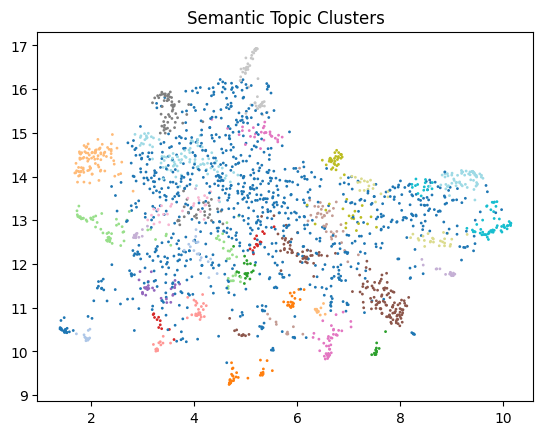

In [43]:
project = umap.UMAP(n_components=2).fit_transform(X_bert)
plt.scatter(project[:, 0], project[:, 1], c=df['cluster_bert'], cmap='tab20', s=1)
plt.title('Semantic Topic Clusters')

### 9.2 Silhouette Comparison

Generating TF-IDF Silhouette Plot...
Generating BERT Silhouette Plot...


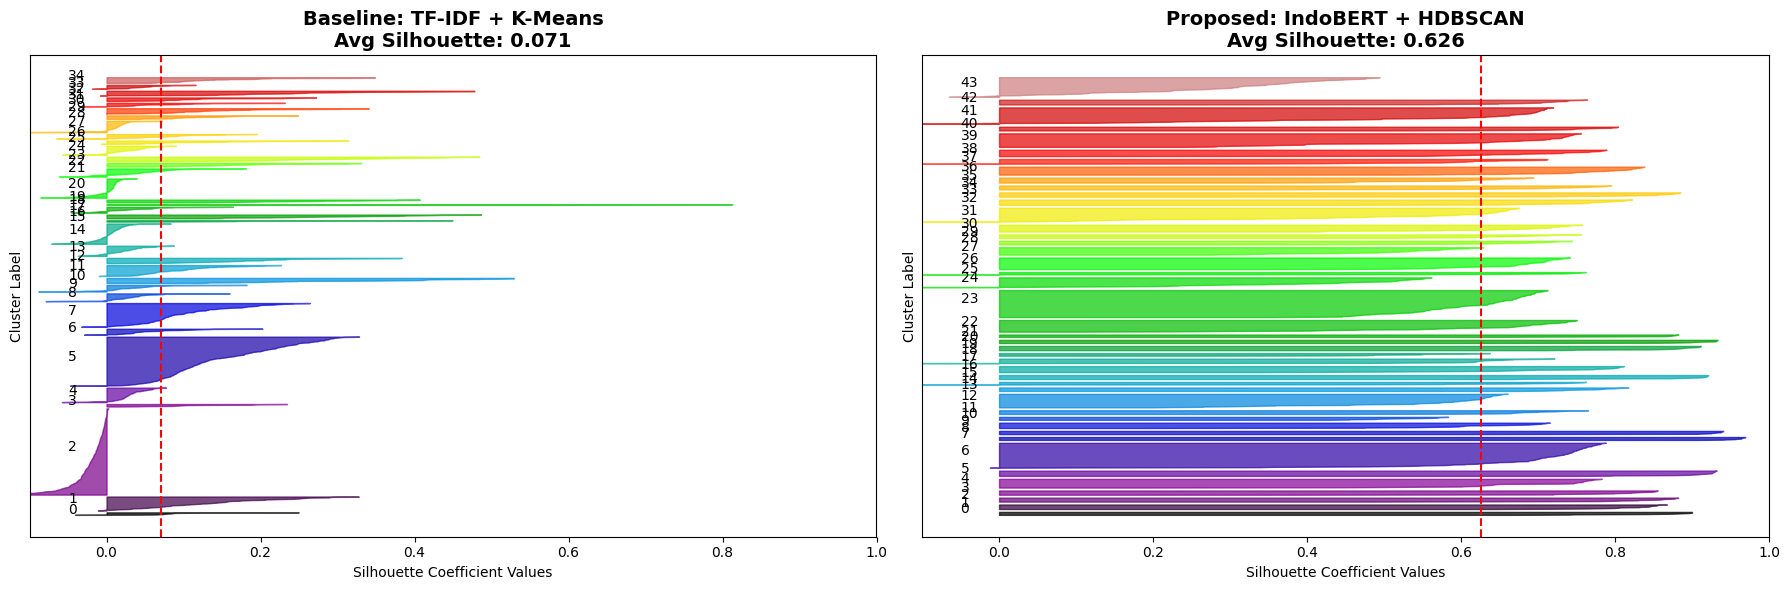

In [44]:
def plot_comparative_silhouette(X_tfidf, labels_tfidf, X_bert, labels_bert):
    """
    Generates a side-by-side Silhouette Plot to compare cluster quality.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Helper to plot one subplot
    def plot_single_silhouette(ax, X, labels, title):
        # Filter out noise (-1) for HDBSCAN fairness
        mask = labels != -1
        if np.sum(mask) < 2:
            ax.text(0.5, 0.5, "Not enough clustered data", ha='center')
            return
            
        X_clean = X[mask]
        labels_clean = labels[mask]
        
        # If X is sparse (TF-IDF), convert to dense for calculation if small enough
        # or use pairwise_distances. For safety, we assume dense or limited size here.
        if hasattr(X_clean, "toarray"):
            X_clean = X_clean.toarray()
            
        n_clusters = len(set(labels_clean))
        silhouette_avg = silhouette_score(X_clean, labels_clean)
        sample_silhouette_values = silhouette_samples(X_clean, labels_clean)

        y_lower = 10
        for i in sorted(list(set(labels_clean))):
            ith_cluster_silhouette_values = sample_silhouette_values[labels_clean == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                             0, ith_cluster_silhouette_values,
                             facecolor=color, edgecolor=color, alpha=0.7)

            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax.set_title(f"{title}\nAvg Silhouette: {silhouette_avg:.3f}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Silhouette Coefficient Values")
        ax.set_ylabel("Cluster Label")
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xlim([-0.1, 1])

    # 1. Plot TF-IDF (K-Means)
    print("Generating TF-IDF Silhouette Plot...")
    plot_single_silhouette(ax1, X_tfidf, df['cluster_tfidf'].values, "Baseline: TF-IDF + K-Means")

    # 2. Plot BERT (HDBSCAN) - utilizing the REDUCED embeddings for fair density comparison
    print("Generating BERT Silhouette Plot...")
    # Note: We use X_bert_reduced because HDBSCAN clusters on that space
    plot_single_silhouette(ax2, X_bert_reduced, df['cluster_bert'].values, "Proposed: IndoBERT + HDBSCAN")

    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
# Ensure you have your X_tfidf, X_bert_reduced and dataframe ready
plot_comparative_silhouette(X_tfidf, df['cluster_tfidf'], X_bert_reduced, df['cluster_bert'])

### 9.3 Clustering Agreement Metrics

In [45]:
print("\n--- 9.3 Clustering Agreement ---")

df_no_noise = df[df['cluster_bert'] != -1].copy()
if len(df_no_noise) > 0:
    ari = adjusted_rand_score(df_no_noise['cluster_tfidf'], df_no_noise['cluster_bert'])
    nmi = normalized_mutual_info_score(df_no_noise['cluster_tfidf'], df_no_noise['cluster_bert'])

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Info (NMI): {nmi:.4f}")
print("\nInterpretation:")
print("  ARI/NMI → 1: High agreement")
print("  ARI/NMI → 0: Low agreement")


--- 9.3 Clustering Agreement ---
Adjusted Rand Index (ARI): 0.2647
Normalized Mutual Info (NMI): 0.5737

Interpretation:
  ARI/NMI → 1: High agreement
  ARI/NMI → 0: Low agreement


### 9.4 Summary Length Analysis

In [46]:
print("\n--- 9.4 Summary Length Statistics ---")
tfidf_lengths = [len(s) for s in tfidf_abstractive.values()]
bert_lengths = [len(s) for s in bert_abstractive.values()]
print(f"\nTF-IDF Summaries:")
print(f"  Mean: {np.mean(tfidf_lengths):.1f} chars")
print(f"  Range: {min(tfidf_lengths)} - {max(tfidf_lengths)}")
print(f"\nBERT Summaries:")
print(f"  Mean: {np.mean(bert_lengths):.1f} chars")
print(f"  Range: {min(bert_lengths)} - {max(bert_lengths)}")


--- 9.4 Summary Length Statistics ---

TF-IDF Summaries:
  Mean: 83.9 chars
  Range: 31 - 182

BERT Summaries:
  Mean: 90.6 chars
  Range: 41 - 199


### Visualization

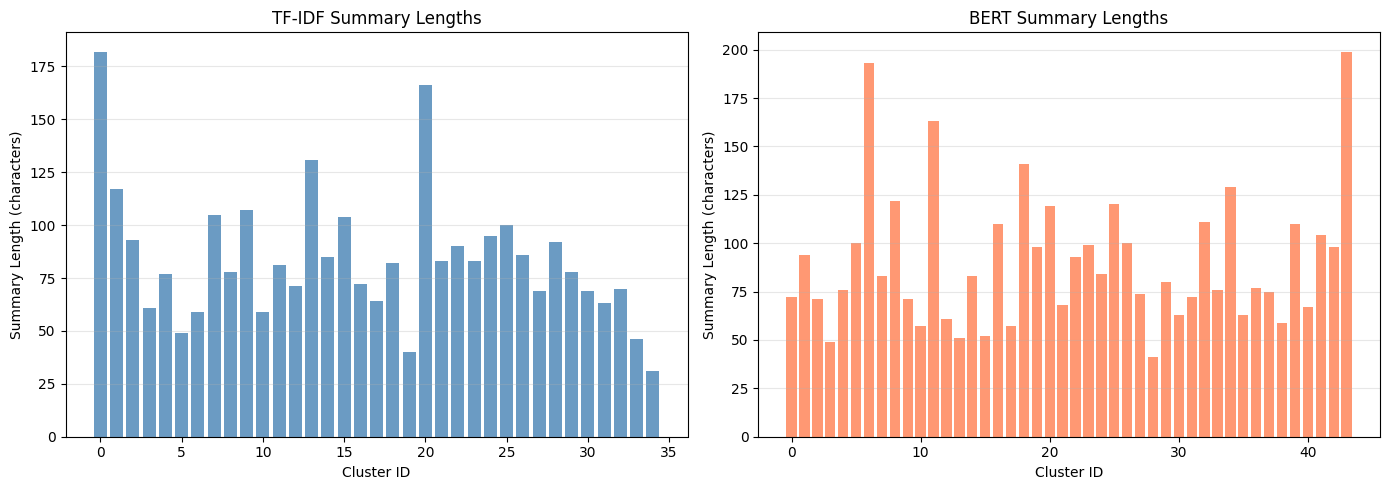

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.bar(sorted(tfidf_abstractive.keys()), tfidf_lengths, color='steelblue', alpha=0.8)
ax1.set_xlabel('Cluster ID')
ax1.set_ylabel('Summary Length (characters)')
ax1.set_title('TF-IDF Summary Lengths')
ax1.grid(axis='y', alpha=0.3)
ax2.bar(sorted(bert_abstractive.keys()), bert_lengths, color='coral', alpha=0.8)
ax2.set_xlabel('Cluster ID')
ax2.set_ylabel('Summary Length (characters)')
ax2.set_title('BERT Summary Lengths')
ax2.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()